In [1]:
# pip install cleantext
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# from cleantext import clean

In [2]:
%%time

def clean_text(text):
    return clean(text,
                fix_unicode=True,               # fix various unicode errors
                to_ascii=True,                  # transliterate to closest ASCII representation
                lower=False,                     # lowercase text
                no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                no_urls=False,                  # replace all URLs with a special token
                no_emails=True,                # replace all email addresses with a special token
                no_phone_numbers=True,         # replace all phone numbers with a special token
                no_numbers=False,               # replace all numbers with a special token
                no_digits=False,                # replace all digits with a special token
                no_currency_symbols=False,      # replace all currency symbols with a special token
                no_punct=False,                 # fully remove punctuation
                replace_with_url="<URL>",
                replace_with_email="<EMAIL>",
                replace_with_phone_number="<PHONE>",
                replace_with_number="<NUMBER>",
                replace_with_digit="0",
                replace_with_currency_symbol="<CUR>",
                lang="en"                       # set to 'de' for German special handling
            )

Wall time: 0 ns


In [3]:
def reuters_news_wire_texts():
    from keras.datasets import reuters

    (x_train, y_train), (x_test, y_test) = reuters.load_data()
    wordDict = {y:x for x,y in reuters.get_word_index().items()}  
    texts = []
    for x in x_train:
        texts.append(" ".join([wordDict.get(index-3) for index in x if wordDict.get(index-3) is not None]))
    return texts, y_train


# Load 20 newsgroup dataset

Alternativ auch nochmal mit sample_5000 probieren.

In [4]:
# import pandas as pd
# from sklearn.datasets import fetch_20newsgroups
# newsgroups_train = fetch_20newsgroups(subset='train')
# newsgroups_test = fetch_20newsgroups(subset='test')
# print(pd.Series(newsgroups_train['data']).str.split().apply(len).quantile(0.9))

# Cleaning

In [5]:
from dlutils import dlutils
import numpy as np
# _input = fetch_20newsgroups(subset='train')['data']
_input, y = reuters_news_wire_texts()
# %time _input = [clean_text(x) for x in _input]
vocab = np.unique([word for text in _input for word in text.split()])

C:\Users\Dlenz\Anaconda3\envs\py36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dlenz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


# Encoding
### Use max_seq_len = 512 for encoding the texts and a smaller max_seq_len to encode the words

In [6]:
_input[10]

'period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

In [58]:
from bert_serving.client import BertClient
import numpy as np
bc = BertClient()


In [59]:
embeddings = bc.encode(_input)
np.save('data/embeddings.npy', embeddings)

C:\Users\Dlenz\Anaconda3\envs\py36\lib\site-packages\bert_serving\client\__init__.py:278: UserWarning: some of your sentences have more tokens than "max_seq_len=512" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [60]:
vocab_vecs = bc.encode(list(vocab))
np.save('data/vocab_vecs.npy', vocab_vecs)

# Load saved text embeddings and word vectors 

In [6]:
vocab_vecs = np.load('data/vocab_vecs.npy')
embeddings = np.load('data/embeddings.npy')

# Word Vector Tests

compare different words for their similarity

In [7]:
import pandas as pd
import sklearn
import sklearn.metrics
vocabdf = pd.DataFrame(np.array(list(vocab)))
vocabdf['vecs'] = list(vocab_vecs)

word1, word2 = 'cat', 'dog'

k1 = vocabdf[vocabdf[0]==word1].vecs.values[0]
k2 = vocabdf[vocabdf[0]==word2].vecs.values[0]
print(k1.shape)
print(k2.shape)
sklearn.metrics.pairwise.cosine_similarity(k1.reshape(1,-1),k2.reshape(1,-1))

(768,)
(768,)


array([[0.9588651]], dtype=float32)

In [8]:
vocab[0:10]

array(["'", "''", "'29", "'at", "'bankrupt", "'event'", "'flight",
       "'give'", "'growth", "'i'm"], dtype='<U24')

# Clustering

### Clustering based on GMM model

In [9]:
import numpy as np
from sklearn.mixture import GaussianMixture
n_topics = 20
gmm = GaussianMixture(n_components=n_topics, covariance_type='full')

%time gmm.fit(embeddings)
topic_assignment = gmm.predict(embeddings)

Wall time: 2min 42s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [10]:
# calculate cluster centers
cluster_centers=list()
for i in range(n_topics):
   # print(i)
    indices = np.where(topic_assignment==i)[0]
    center = np.array(embeddings)[indices].mean(axis=0)
    cluster_centers.append(center)

Wall time: 10min 45s


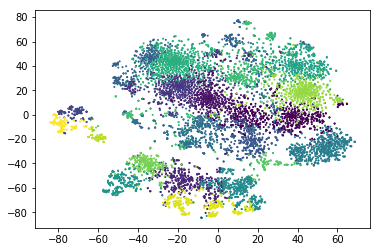

In [11]:
# break down the dimension of vectors to visualize the distribution of the embedded texts and cluster centers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE()
%time d2vecs = tsne.fit_transform(np.vstack([embeddings, cluster_centers]))
plt.scatter(d2vecs[:embeddings.shape[0], 0], d2vecs[:embeddings.shape[0], 1],c=topic_assignment, s=1)

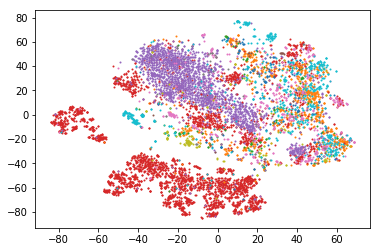

In [12]:
# reuters news wire clustering
for i in range(n_topics):
    indices = np.where(y==i)[0]
    vecs = d2vecs[indices]
    plt.scatter(vecs[:, 0], vecs[:, 1], s=1)
    

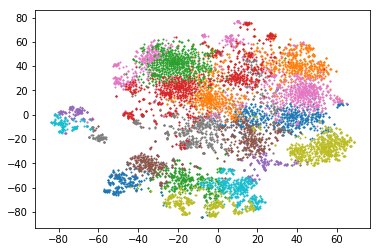

In [13]:
for i in range(n_topics):
    indices = np.where(topic_assignment==i)[0]
    vecs = d2vecs[indices]
    plt.scatter(vecs[:, 0], vecs[:, 1], s=1)
    

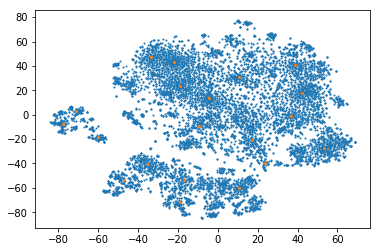

In [14]:
plt.scatter(d2vecs[:embeddings.shape[0], 0], d2vecs[:embeddings.shape[0], 1], s=1)
plt.scatter(d2vecs[embeddings.shape[0]:, 0], d2vecs[embeddings.shape[0]:, 1], s=4)

In [15]:
len(topic_assignment)
type(_input)

8982

list

# Choose words for cluster representation 

In [73]:
d ={'texts': _input, 'assignment': topic_assignment}
clusters_df = pd.DataFrame(data=d)
clusters_df.head()

,texts,assignment
0,mcgrath rentcorp said as a result of its decem...,7
1,generale de banque sa lt genb br and lt heller...,3
2,shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs ...,9
3,the farmers home administration the u s agricu...,16
4,seton co said its board has received a proposa...,3


## Common word removal

In [132]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
data_set = clusters_df.texts
data_set = ''.join(data_set)
stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
word_tokens = word_tokenize(data_set) 
data_set = [w for w in word_tokens if not w in stop_words] 
data_set = [x for x in data_set if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]

freq = pd.Series(' '.join(data_set).split()).value_counts()

In [133]:
freq[:10]

's           8841
january      1422
co           1416
agreement    1405
offer        1403
three        1377
told         1371
could        1364
note         1341
today        1333
dtype: int64

In [137]:
filter_rate = 150
print('Filter out', filter_rate, 'words')
#freq.index[:filter_rate]

Filter out 150 words


In [138]:
freq = list(freq.index[:filter_rate])
clusters_df['texts'] = clusters_df['texts'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

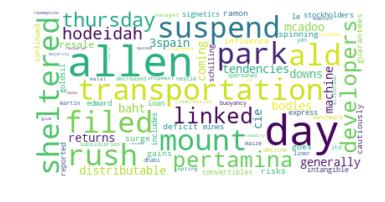

In [83]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections 
cluster_number=5
words_topic=100

data_set = clusters_df.texts[clusters_df.assignment==cluster_number]
data_set = ''.join(data_set)
stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
word_tokens = word_tokenize(data_set) 
data_set = [w for w in word_tokens if not w in stop_words] 

counter = collections.Counter(data_set)
new_list= sorted( data_set, key=lambda x: (counter[x], x), reverse=True )
new_list= list(set(new_list))
#new_list = [x for x in new_list if not (x.isdigit() 
#                                         or x[0] == '-' and x[1:].isdigit())]

text = new_list[0:words_topic]
text = ', '.join(text)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [139]:
top_words = pd.DataFrame()
for i in range(n_topics):
    data_set = clusters_df.texts[clusters_df.assignment==i]
    data_set = ''.join(data_set)
    stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
    word_tokens = word_tokenize(data_set) 
    data_set = [w for w in word_tokens if not w in stop_words] 
    counter = collections.Counter(data_set)
    new_list= sorted( data_set, key=lambda x: (counter[x], x), reverse=True )
    new_list= list(set(new_list))
    new_list = [x for x in new_list if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]
    topic_df = pd.DataFrame(new_list[:20])
    top_words = pd.concat([top_words,topic_df], axis=1)
    #top_words.iloc[:,i+1]= new_list[:20]
    #print(new_list[:20])

In [140]:
mylist= list(range(1, 21))
top_words.columns = ['topic_' + str(s) for s in mylist]

In [141]:
top_words.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,plaintiff,paperboard,reversl,solid,seven,allen,engineering,solid,jeopardising,engineering,na,bruno,solid,paperboard,pool,na,reporter,seven,non,seven
1,reporter,3corby,na,tasmanian,restated,transportation,na,3result,geographically,na,qtly,huntington,substnatial,appropriateness,engineering,gross,reinforced,great,qtly,company
2,reinforced,cardiology,audio,pool,qtr,mount,ras,ionic,reinbursement,audio,brook,catarina,electromagnetic,engineering,na,3diluted,day,qtr,sasles,qtr
3,convenience,ferrosilicon,resolution,engineering,qtly,filed,audio,engineering,reporter,mississippi,gross,regret,3foote,na,jly,risk,regret,qtly,class,qtly
4,ministries,allen,gross,debbie,development,ald,tunisia,na,reinforced,container,nov,assure,rjr,reinforced,huntington,cumulative,allen,medical,32nd,development


In [143]:
top_words.to_csv('top_words_20_topics.csv')

In [111]:
import nltk
test= nltk.word_tokenize(text)
nltk.pos_tag(test)

[('herb', 'NN'),
 (',', ','),
 ('dislike', 'NN'),
 (',', ','),
 ('milan', 'NN'),
 (',', ','),
 ('members', 'NNS'),
 (',', ','),
 ('citt', 'NN'),
 (',', ','),
 ('learning', 'NN'),
 (',', ','),
 ('dump', 'NN'),
 (',', ','),
 ('outlining', 'VBG'),
 (',', ','),
 ('civil', 'JJ'),
 (',', ','),
 ('valve', 'FW'),
 (',', ','),
 ('squabble', 'JJ'),
 (',', ','),
 ('jail', 'NN'),
 (',', ','),
 ('basis', 'NN'),
 (',', ','),
 ('dougherty', 'NN'),
 (',', ','),
 ('praise', 'NN'),
 (',', ','),
 ('bernard', 'NN'),
 (',', ','),
 ('idling', 'VBG'),
 (',', ','),
 ('auxiliaire', 'NN'),
 (',', ','),
 ('lean', 'JJ'),
 (',', ','),
 ('violations', 'NNS'),
 (',', ','),
 ('incorporate', 'NN'),
 (',', ','),
 ('nothing', 'NN'),
 (',', ','),
 ('ever', 'RB'),
 (',', ','),
 ('site', 'NN'),
 (',', ','),
 ('suleiman', 'NN'),
 (',', ','),
 ('instruments', 'NNS'),
 (',', ','),
 ('wise', 'NN'),
 (',', ','),
 ('budgeted', 'VBN'),
 (',', ','),
 ('businesess', 'NN'),
 (',', ','),
 ('cement', 'NN'),
 (',', ','),
 ('avondale', 

In [113]:
for i in range(n_topics):
    words_topic=100
    data_set = clusters_df.texts[clusters_df.assignment==i]
    data_set = ''.join(data_set)
    stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
    word_tokens = word_tokenize(data_set) 
    data_set = [w for w in word_tokens if not w in stop_words] 
    counter = collections.Counter(data_set)
    new_list= sorted( data_set, key=lambda x: (counter[x], x), reverse=True )
    new_list= list(set(new_list))
    new_list = [x for x in new_list if not (x.isdigit() 
                                         or x[0] == '-' and x[1:].isdigit())]
    print(new_list[:25])

['members', 'outlining', 'civil', 'rionda', 'speyer', 'basis', 'auburn', '3jorge', 'extrusion', 'violations', 'site', 'nothing', 'ever', 'instruments', 'cement', 'shultz', 'chrysler', 'co', 'ordered', 'inventory', 'accepts', 'ignored', 'bringing', 'afraid', 'favorable']
['requirement', 'unitholders', 'members', 'official', 'january', 'began', 'scott', 'half', 'coconut', 'proven', 'concluded', 'commodity', 'overseeing', 'quarter', 'time', 'toward', 'offering', 'gyllenhammar', 'reviews', 'basis', 'boston', 'arrivals', 'tools', 'agency', 'risen']
['milan', 'members', 'citt', 'unsubscribed', 'outlining', 'civil', 'jail', 'basis', 'queried', 'extrusion', 'mediterranee', 'violations', 'incorporate', 'sek', 'nothing', 'ever', 'site', 'suleiman', 'instruments', 'cement', 'denationalisation', 'shultz', 'chrysler', 'co', 'ordered']
['matthey', 'overtime', 'january', 'began', 'half', 'proven', 'offering', 'quarter', 'time', 'basis', '1p', 'w', 'koninklijke', 'affiliate', '3south', 'vmnb', 'settle

In [92]:
%time adsf = pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(vocab_vecs))

In [118]:
adsf.iloc[18021].sort_values(ascending=False)
vocab[16814]

'mission'

In [70]:
# Choose topic number and number of words should be used for the word cloud 
topic_number= 7
words_topic=100
res_topic=[]
for res in results[topic_number]:
    res_topic.append(res)

d ={'word': list(vocab), 'cosine_sim': res_topic}
topic_df = pd.DataFrame(data=d)

topic_sorted = topic_df.sort_values(by=['cosine_sim'],ascending=False)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = topic_sorted['word'][0:words_topic].tolist()
text = ', '.join(text)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

NameError: name 'results' is not defined

# LDA

In [144]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

tf =TfidfVectorizer()
lda = LatentDirichletAllocation(n_topics)

%time tfvecs = tf.fit_transform(_input)
%time lda_vecs = lda.fit_transform(tfvecs)


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

n_top_words=10
print("\nTopics in LDA model:")
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Wall time: 715 ms
Wall time: 21.9 s

Topics in LDA model:
Topic #0: ccc taft bonus guarantees corporation credit commodity walker enhancement guarantee
Topic #1: slaughter ago pdvsa head starts units venezuela adjusted versus multi
Topic #2: guinness dibona 648 swire gte connecticut hecla sprint crime webb
Topic #3: coffee ico quotas ecuador colombia dauster santos fairchild venezuela westminster
Topic #4: supermarkets dart pl utilicorp saudis petrobras hudson atcor 062 789
Topic #5: hawley carter spectra physics valor 820 hale ciba geigy ortner
Topic #6: trade japanese tariffs yeutter gatt japan lyng the ec nakasone
Topic #7: 744 amstutz cenergy undersecretary catches bryson rent credited allocated myers
Topic #8: stg the bank mln of bills england fed market band
Topic #9: genova resorts interco lane bilzerian meat mechanically separated loom nwbl
Topic #10: petrol octane gm ultramar pump gelco ranchman lazere litre cray
Topic #11: 728 793 476 988 617 526 537 459 029 068
Topic #12: ir